In [1]:
import os

if not os.path.exists("VoxCeleb_gender"):
    !pip install gdown pydub librosa
    !gdown https://drive.google.com/uc?id=1V3lNnSDv71AJYIj71V4_xD0ir0DrXxEV
    !tar -xf VoxCeleb_gender.zip #!tar -xf VoxCeleb_gender.zip
    !del VoxCeleb_gender.zip     #!del

else:
    print("Dataset already downloaded.")

Dataset already downloaded.


In [2]:
import librosa
import scipy.signal as ss
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

def extract_mfcc(file_path, n_mfcc=12, win_length=320, hop_length=160):
    wave, sr = librosa.load(file_path, mono=True, sr=None)
    if sr != 16000:
        wave = librosa.resample(wave, sr, 16000)
    mfcc = librosa.feature.mfcc(y=wave, sr=16000, n_mfcc=n_mfcc, window=ss.windows.hamming, win_length=win_length, hop_length=hop_length)
    return mfcc

# Build data in memory

In [3]:
mfcc_coeff_amount = 12
window_length = int(16000*0.02)

In [4]:
arr = []
if not os.path.exists(f"mfcc_{mfcc_coeff_amount}_{window_length}.pkl"):

    aux = []

    for (dirpath, dirnames, filenames) in os.walk("VoxCeleb_gender"):
        for filename in filenames:
            if filename.endswith(".wav"):
                filepath = dirpath + "/" + filename
                aux.append({"file": filepath, "gender": dirpath.split("\\")[-1]})

    df = pd.DataFrame(aux)

    df["mfcc"] = pd.Series(name="mfcc", dtype=object)

    for i in range(len(df)):
        mfcc_coeffs = extract_mfcc(df.loc[i, "file"], n_mfcc=mfcc_coeff_amount, win_length=window_length)
        for i, coeffs in enumerate(mfcc_coeffs):
            if np.linalg.norm(coeffs) < 1:
                mfcc_coeffs.pop(i)
        arr.append(mfcc_coeffs)
    df["mfcc"] = arr
    df.to_pickle(f"mfcc_{mfcc_coeff_amount}_{window_length}.pkl")
else:
    print("File Found")
    df = pd.read_pickle(f"mfcc_{mfcc_coeff_amount}_{window_length}.pkl")


num_males = len(df.loc[df.gender == "males"] )           
num_females = len(df.loc[df.gender == "females"] )              

File Found


In [5]:
print("Number of males: ", num_males)
print("Number of females: ", num_females)

Number of males:  3682
Number of females:  2311


In [6]:
display(df) #Cada fila tiene los datos de un audio, cada columna mfcc contiene n_mfcc x timesteps 

,file,gender,mfcc
0,VoxCeleb_gender/males/255.wav,males,"[[-266.89233, -288.64322, -288.0051, -277.8506..."
1,VoxCeleb_gender/males/1908.wav,males,"[[-362.22406, -338.4697, -335.41837, -333.9136..."
2,VoxCeleb_gender/males/2965.wav,males,"[[-407.10593, -375.89368, -386.202, -388.78607..."
3,VoxCeleb_gender/males/2733.wav,males,"[[-299.1009, -257.6437, -261.46454, -229.911, ..."
4,VoxCeleb_gender/males/3091.wav,males,"[[-259.80472, -288.65842, -285.53375, -291.276..."
...,...,...,...
5988,VoxCeleb_gender/females/489.wav,females,"[[-439.62015, -451.93927, -449.33908, -452.043..."
5989,VoxCeleb_gender/females/941.wav,females,"[[-327.78085, -321.0226, -342.2135, -330.92526..."
5990,VoxCeleb_gender/females/63.wav,females,"[[-408.27185, -391.82303, -360.8797, -308.7707..."
5991,VoxCeleb_gender/females/1820.wav,females,"[[-365.03598, -326.88446, -337.80292, -328.621..."


In [7]:
from sklearn.model_selection import train_test_split

#Equalize number of gender in dataset
# gender_counts = df['gender'].value_counts()
# difference = abs(gender_counts['males'] - gender_counts['females'])
# if gender_counts['males'] > gender_counts['females']:
#     df_balanced = df.drop(df[df['gender'] == 'males'].sample(n=difference, random_state=42).index)
# else:
#     df_balanced = df.drop(df[df['gender'] == 'females'].sample(n=difference, random_state=42).index)

#Split into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(df.drop(['gender'], axis=1), df['gender'], test_size=0.2)
X_file, X_test_file = X_train["file"], X_test["file"]
X_train.drop(["file"], inplace=True, axis=1)
X_test.drop(["file"], inplace=True, axis=1)


# EDA

In [8]:
# Get the mean mfcc coefficients for each class
mean_mfcc_males = 0
mean_mfcc_females = 0

for person in df.iterrows():
    for i in range(len(person[1]["mfcc"])//mfcc_coeff_amount):
        if person[1]["gender"] == "males":
            mean_mfcc_males = np.mean(np.array(person[1]["mfcc"]), axis=1)/num_males
        else:
            mean_mfcc_females = np.mean(person[1]["mfcc"], axis=1)/num_females

display(mean_mfcc_males)
display(mean_mfcc_females)

array([-0.11972281,  0.02990563, -0.01197125,  0.00156714, -0.0089404 ,
       -0.00567426, -0.00416346, -0.00176591, -0.00151322, -0.00049492,
       -0.00278864,  0.00304949], dtype=float32)

array([-0.1156978 ,  0.03775504, -0.00754318,  0.00508091, -0.01344521,
       -0.01013145, -0.00357516, -0.00078147,  0.00039397,  0.00086333,
       -0.0044957 , -0.00069347], dtype=float32)

In [9]:
score_males = []
score_females = []

for i in range(1000):
    score_males.append(np.sum(df.mfcc[df.gender=="males"][i], axis=1) @ mean_mfcc_males)
    score_females.append(np.sum(df.mfcc[df.gender=="females"][i + num_males], axis=1) @ mean_mfcc_males)


(array([484., 349.,  97.,  36.,  19.,   3.,   4.,   2.,   1.,   1.,   1.,
          0.,   0.,   0.,   0.,   1.,   0.,   1.,   0.,   1.]),
 array([  6138.01416016,  24842.1796875 ,  43546.34375   ,  62250.5078125 ,
         80954.671875  ,  99658.8359375 , 118363.        , 137067.171875  ,
        155771.328125  , 174475.5       , 193179.65625   , 211883.828125  ,
        230588.        , 249292.15625   , 267996.3125    , 286700.5       ,
        305404.65625   , 324108.8125    , 342812.96875   , 361517.15625   ,
        380221.3125    ]),
 <BarContainer object of 20 artists>)

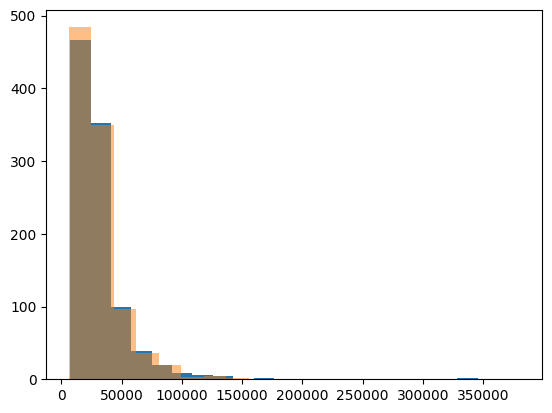

In [10]:
plt.hist(score_males, bins=20)
plt.hist(score_females, bins=20, alpha=0.5)

# GMM Model

In [11]:
amount = 50
X_male = np.concatenate(X_train.mfcc[y_train=="males"].to_numpy(), axis=1).T
X_female = np.concatenate(X_train.mfcc[y_train=="females"].to_numpy(), axis=1).T
X_test_male = np.concatenate(X_test.mfcc[y_test=="males"].to_numpy(), axis=1).T
X_test_female = np.concatenate(X_test.mfcc[y_test=="females"].to_numpy(), axis=1).T

In [12]:
X_test[y_test=="females"]

,mfcc
5946,"[[-425.19046, -366.16733, -381.6103, -376.2021..."
5271,"[[-79.497, -176.06187, -178.89726, -152.91866,..."
5875,"[[-98.62898, -148.81029, -151.65239, -154.2018..."
4953,"[[-302.73074, -261.19232, -258.62946, -251.660..."
5668,"[[-462.1628, -403.28607, -404.11304, -320.0429..."
...,...
5950,"[[-231.13893, -216.07805, -213.55646, -208.150..."
5163,"[[-455.0844, -409.65436, -397.60992, -421.5381..."
4341,"[[-332.34454, -396.08414, -362.15305, -327.213..."
5269,"[[-286.37814, -301.54773, -306.99158, -299.571..."


In [13]:
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV

gmm_male = GaussianMixture(n_components=mfcc_coeff_amount, covariance_type='full', max_iter=1000)
gmm_female = GaussianMixture(n_components=mfcc_coeff_amount, covariance_type='full', max_iter=1000)

gmm_male.fit(X_male)
gmm_female.fit(X_female)

KeyboardInterrupt: 

In [ ]:
import pickle

with open('gmm_male.pkl','wb') as f:
    pickle.dump(gmm_male,f)

with open('gmm_female.pkl','wb') as f:
    pickle.dump(gmm_female,f)

In [15]:
import pickle

with open('gmm_male.pkl','rb') as f:
    gmm_male = pickle.load(f)

with open('gmm_female.pkl','rb') as f:
    gmm_female = pickle.load()

TypeError: load() takes exactly 1 positional argument (2 given)

(array([0.00181681, 0.00726723, 0.04360339, 0.05813785, 0.09447401,
        0.15987909, 0.22528417, 0.14171101, 0.08902358, 0.04178658,
        0.01090085, 0.00181681, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.  

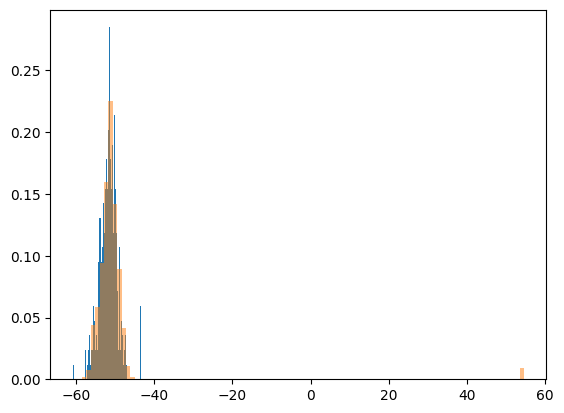

In [ ]:
# Lo importante de estos scores es cuanto suman
person = 1
plt.hist(gmm_female.score_samples(X_test.mfcc.iloc[person].T), bins=100, density = True)
plt.hist(gmm_male.score_samples(X_test.mfcc.iloc[person].T), bins=100, density = True, alpha=0.5)

In [ ]:
scores_fgmm = pd.Series(index=y_test.index)
scores_mgmm = pd.Series(index=y_test.index)

for index, row in X_test.iterrows():
    mfcc = row['mfcc']
    scores_fgmm[index] = gmm_female.score_samples(mfcc.T).mean()
    scores_mgmm[index] = gmm_male.score_samples(mfcc.T).mean()

/tmp/ipykernel_4744/4085554593.py:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  scores_fgmm = pd.Series(index=y_test.index)
/tmp/ipykernel_4744/4085554593.py:2: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  scores_mgmm = pd.Series(index=y_test.index)


In [ ]:
display(scores_mgmm[y_test == "males"].mean())
display(scores_mgmm[y_test == "females"].mean())

-36496.09768028889

-40801.71753861897

(array([2.95257820e-07, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 2.95257820e-07, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.000000

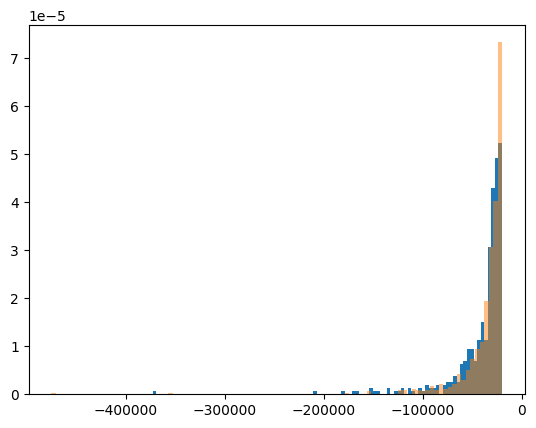

In [ ]:
plt.figure()
plt.hist(scores_mgmm[y_test == "females"][:1000], bins=100, density = True)
plt.hist(scores_mgmm[y_test == "males"][:1000], bins=100, density = True, alpha=0.5)


In [ ]:
predictions = []
for index in y_test.index:
    if scores_mgmm[index] > scores_fgmm[index]:
        predictions.append('males')
    else:
        predictions.append('females')

# Convert predictions to a pandas Series
predictions = pd.Series(predictions, index=y_test.index)

# Calculate the accuracy
accuracy = (predictions == y_test).mean()

# Print the accuracy
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 87.24%


# Busqueda de hiperparametros

In [ ]:
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV


def gmm_bic_score(estimator, X):
    # Make it negative since GridSearchCV expects a score to maximize
    return -estimator.bic(X)


param_grid = {
    "n_components": range(8, 13),
    "covariance_type": ["full", "tied", "diag", "spherical"],
}

grid_search = GridSearchCV(GaussianMixture(), param_grid=param_grid, scoring=gmm_bic_score)
grid_search.fit(X_male)

KeyboardInterrupt: 

In [ ]:
import pandas as pd

df = pd.DataFrame(grid_search.cv_results_)[
    ["param_n_components", "param_covariance_type", "mean_test_score"]
]
df["mean_test_score"] = -df["mean_test_score"]
df = df.rename(
    columns={
        "param_n_components": "Number of components",
        "param_covariance_type": "Type of covariance",
        "mean_test_score": "BIC score",
    }
)
df.sort_values(by="BIC score").head()

,Number of components,Type of covariance,BIC score
10,8,diag,-33461.914926
11,9,diag,-33442.472437
12,10,diag,-33374.092174
13,11,diag,-33264.468986
5,8,tied,-33140.519868


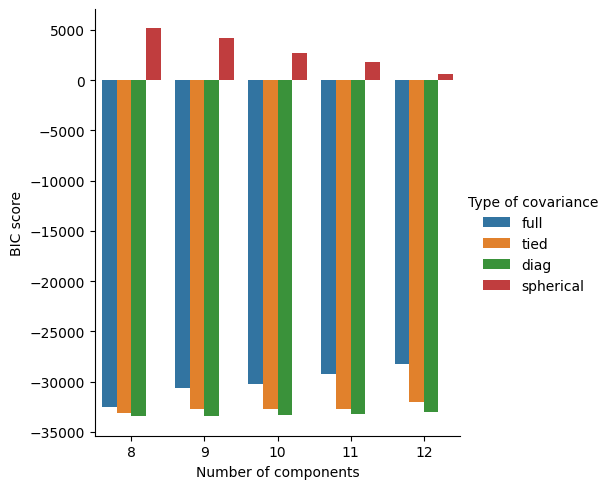

In [ ]:
import seaborn as sns

sns.catplot(
    data=df,
    kind="bar",
    x="Number of components",
    y="BIC score",
    hue="Type of covariance",
)
plt.show()